# L2 FWI Example
We will solve this problem using the following steps:
1. Read the true and starting models from binary files coarsen them and visualize
2. Build up a small local compute cluster and load packages onto the compute cluster
3. Build F, the forward modeling operator
4. Use F and the true model to create a synthetic data-set
5. Build the gradient and cost functions
6. Do the FWI using optim.jl

In [1]:
using PyPlot, Distributed

### 1. Read the true and starting models from binary files coarsen them and visualize

In [2]:
v  = read!("../marmousi_20m_nz151_nx461.bin", Array{Float32}(undef, 151,461))
v  *= 1000 #change to m/s
vₒ = read!("../marmousi_smoothed_20m_nz151_nx461.bin", Array{Float32}(undef, 151,461))
vₒ *= 1000 #change to m/s;

In [3]:
v = v[1:2:end,1:2:end]
vₒ = vₒ[1:2:end,1:2:end];

In [4]:
dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (76, 231)


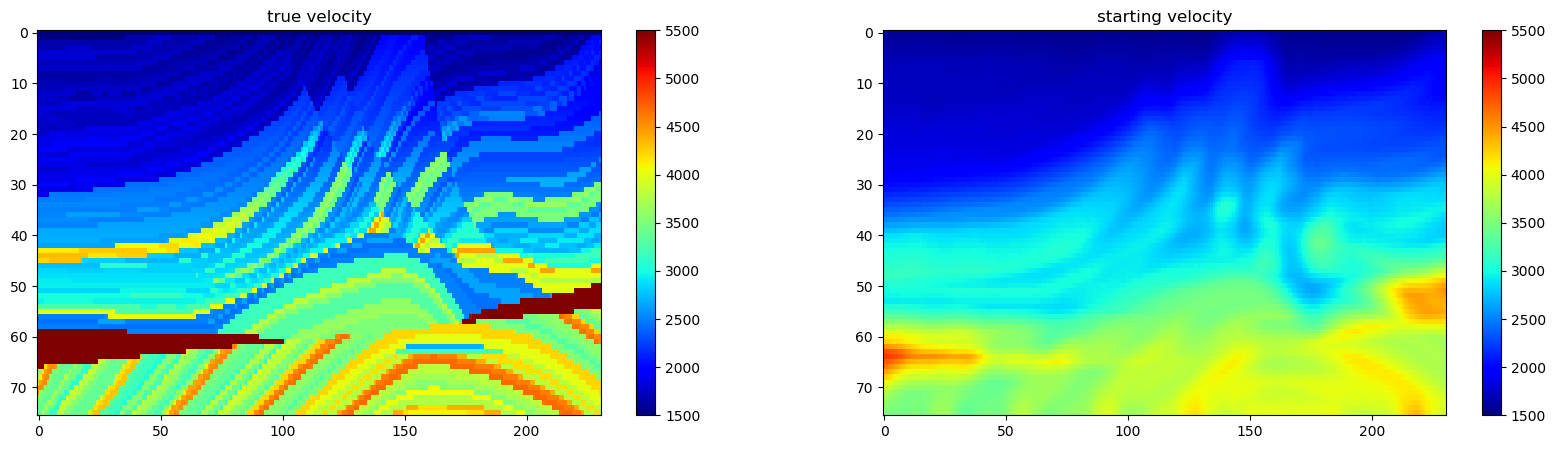

In [5]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1500,5500);title("true velocity")
subplot(122);imshow(vₒ,aspect="auto",cmap="jet");colorbar();clim(1500,5500);title("starting velocity");

### 2. Build up a small local compute cluster and load packages onto the compute cluster

In [6]:
addprocs(4);

In [7]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, JetPackWave, LinearAlgebra, LineSearches, Optim, Wave, Random

### 3. Build F, the forward modeling operator

10 shot locations (onyl using 10 because we are using our local machines to run the FWI)

In [8]:
sx = (0.0:dx*12:(nx-1)*dx)
nshots = length(sx)
@show nshots;

nshots = 20


In [19]:
@everywhere function makeF(i,peakfreq,sx,nz,nx,dz,dx)
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        comptype = UInt32,
        ntrec = 1101,
        dtrec = 0.004,
        dtmod = 0.001,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=peakfreq),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:0.5:nx-1;],
        rz = 2*dz*ones(461),
        srcfieldfile = "/local/tmp/field-$(i)-$(randstring()).bin",
        reportinterval=0)
end

In [20]:
F = @blockop DArray(I->[makeF(i,3.0,sx,nz,nx,dz,dx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (76, 231) → (10151220,)"

### 4. Use F and the true model to create a synthetic data-set

In [21]:
@time begin
    d = F*v;
end

184.027326 seconds (11.93 M allocations: 589.832 MiB, 0.14% gc time)


10151220-element DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}:
  0.0
 -9.882838f-6
 -0.00014099479
 -0.0006735187
 -0.0020313587
 -0.004722827
 -0.009267838
 -0.01613317
 -0.025695436
 -0.038244344
 -0.054028604
 -0.073336326
 -0.096593946
  ⋮
 -0.3791034
 -0.4390664
 -0.4970537
 -0.5524287
 -0.60458034
 -0.6529311
 -0.69694453
 -0.73613006
 -0.77004594
 -0.7983015
 -0.8205619
 -0.83655053

Plot a subset of shot gathers from the in-memory distributed array

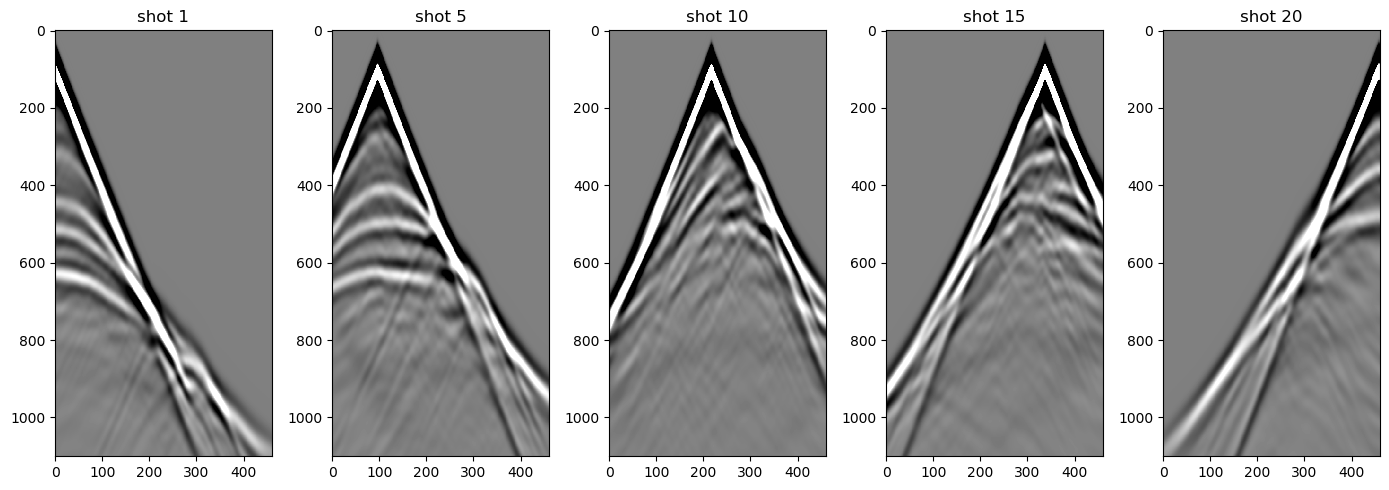

In [22]:
ishots = [1, 5, 10, 15, 20]
figure(figsize=(14,5))
for (iplot,ishot) in enumerate(ishots)
    subplot(1,5,iplot);imshow(getblock(d,ishot)[:,:,1],cmap="gray",aspect="auto",clim=[-10,10]);title("shot $(ishot)");
end
tight_layout()

### 5. Build the gradient and cost functions

In [31]:
function gradient!(G,F,v,dobs,p)
    J = jacobian(F,v)
    s = srcillum(J)
    s .= (s ./ maximum(s)) .+ 1e-8
    R = JopDiagonal((1 ./ s).^2)
    G .= R' ∘ J' * (dobs - F*v)
    if p.gscale == 0.0
       p.gscale = 10 ./ maximum(G)
    end
    G .*= p.gscale
    
    close(F) #delete local files
end
mutable struct FwiPar
   gscale
end
p = FwiPar(0.0)
g!(G,x) = gradient!(G,F,x,d,p)

g! (generic function with 1 method)

In [32]:
grad = zeros(Float32,size(v))
g!(grad,vₒ)

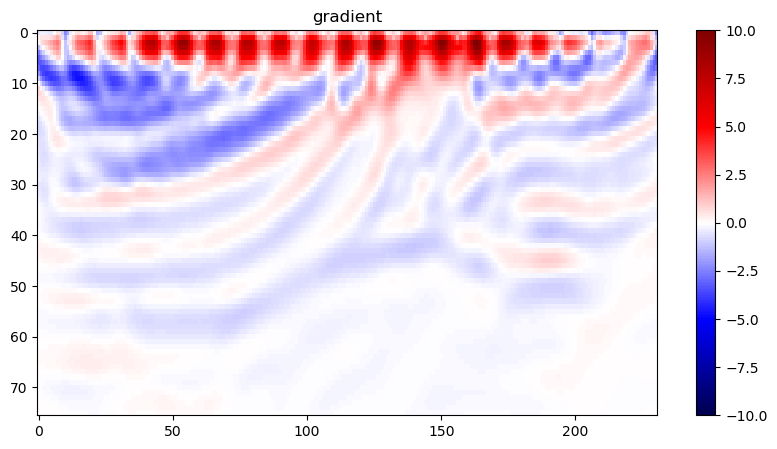

In [33]:
figure(figsize=(10,5))
imshow(grad,aspect="auto",cmap="seismic");colorbar();clim(-10,10);title("gradient");

In [26]:
function cost(x,F,d)
    phi = norm(d .- F*x)
    return phi
    close(F) #delete local files
end
f(x) = cost(x,F,d)

f (generic function with 1 method)

In [27]:
@info "initial cost $(f(vₒ))";

┌ Info: initial cost 12313.764
└ @ Main In[27]:1


### 6. Do the FWI using optim.jl

In [ ]:
solver = LBFGS(m = 20, alphaguess = LineSearches.InitialQuadratic(), linesearch = LineSearches.MoreThuente());

In [ ]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

In [ ]:
redirect_stdout(open("/dev/null","w")) # otherwise the models are printed to stdout at every iteration
result = optimize(f, g!, vₒ, solver,
    Optim.Options(
        iterations = 100,
        show_trace = true,
        store_trace = true,
        show_every = 1,
        extended_trace = true,
        allow_f_increases = true,
        callback = mycallback))

In [ ]:
vfwi = Optim.minimizer(result) # optimal solution
ϕ = Optim.f_trace(result)   # cost vs iteration
m = Optim.x_trace(result)   # model vs iteration

In [ ]:
rmprocs(workers())

In [ ]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1.5,5.5);title("true velocity")
subplot(122);imshow(vfwi,aspect="auto",cmap="jet");colorbar();clim(1.5,5.5);title("fwi velocity");